In [ ]:
# importing modules
from finiteelementanalysis import pre_process as pre
from finiteelementanalysis import pre_process_demo_helper_fcns as pre_demo
from finiteelementanalysis.solver import hyperelastic_solver
from finiteelementanalysis import discretization as di
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# definning a fucntion for getting the number of DoF for a mesh
def calc_mesh_dof( ele_type, coords):
    _, ndof, _ = di.element_info(ele_type)
    n_nodes = coords.shape[0]
    mesh_ndof = ndof * n_nodes
    return mesh_ndof

def solve_hyperelastic_rect_mesh(ele_type, L_x, L_y, N_x, N_y, q, nr_num_steps):
    """Solves a 2D hyperelastic problem on a rectangular mesh."""
    
    #--- Mesh Parameters ---
    origin_x, origin_y = 0.0, 0.0
    num_gauss_pts = 1  # Currently unused

    #--- Get Element Info ---
    _, ndof, _ = di.element_info(ele_type)

    #--- Generate Mesh ---
    coords, connect = pre.generate_rect_mesh_2d(
        ele_type,
        origin_x, origin_y,
        origin_x + L_x, origin_y + L_y,
        N_x, N_y
    )

    #--- Define Boundaries ---
    boundary_nodes, boundary_edges = pre.identify_rect_boundaries(
        coords, connect, ele_type,
        origin_x, origin_x + L_x,
        origin_y, origin_y + L_y
    )

    # Fixed boundary on the left edge: u_x = u_y = 0
    fixed_nodes = pre.assign_fixed_nodes_rect(boundary_nodes, "left", 0.0, 0.0)

    # Apply uniform load on the right edge in x-direction
    dload_info = pre.assign_uniform_load_rect(boundary_edges, "right", 0.0, q)

    #--- Material Properties ---
    mu = 10.0
    kappa = 1000.0
    material_props = np.array([mu, kappa])

    # Optional: derived properties for reference
    nu = (3 * kappa - 2 * mu) / (6 * kappa + 2 * mu)
    E = 2 * mu * (1 + nu)

    #--- Solve Nonlinear Problem ---
    displacements_all, nr_info_all = hyperelastic_solver(
        material_props,
        ele_type,
        coords.T,
        connect.T,
        fixed_nodes,
        dload_info,
        nr_print=True,
        nr_num_steps=nr_num_steps,
        nr_tol=1e-9,
        nr_maxit=30
    )

    return coords, connect, displacements_all


In [16]:
#--- Geometry Parameters ---
ratio = 5
L_y = 1                          # Width
L_x = ratio * L_y               # Length

#--- Mesh Sizes: (N_x, N_y) ---
mesh_size_lst = [
    (ratio * 4, 4),
    (ratio * 10, 10),
    (ratio * 20, 20),
    (ratio * 40, 40)
]
# mesh_size_lst = [(ratio * 4, 4)]  # For quick testing

#--- Element and Solver Setup ---
ele_type = 'D2_nn4_quad'        # Type of element for the mesh
q = -0.05                       # Applied traction in x-direction
nr_num_steps = 10               # Number of Newton-Raphson steps

#--- Run Simulation and Collect Results ---
meshsize2result_D2nn4quad_dict = {'ele_type': ele_type}

for mesh_size in mesh_size_lst:
    N_x, N_y = mesh_size
    coords, connect, displacements_all = solve_hyperelastic_rect_mesh(
        ele_type, L_x, L_y, N_x, N_y, q, nr_num_steps
    )
    mesh_ndof = calc_mesh_dof(ele_type, coords)
    meshsize2result_D2nn4quad_dict[mesh_size] = (
        coords,
        connect,
        displacements_all[-1],  # Final displacement field
        mesh_ndof
    )


Step 0, load factor = 0.100
Iteration 1, Correction=1.000000e+00, Residual=1.113589e-05, tolerance=1.000000e-09
Iteration 2, Correction=2.262452e-03, Residual=2.613646e-04, tolerance=1.000000e-09
Iteration 3, Correction=9.430795e-08, Residual=8.634474e-09, tolerance=1.000000e-09
Iteration 4, Correction=1.436306e-13, Residual=1.671580e-15, tolerance=1.000000e-09
Step 1, load factor = 0.200
Iteration 1, Correction=4.999944e-01, Residual=1.113589e-05, tolerance=1.000000e-09
Iteration 2, Correction=1.131342e-03, Residual=2.613437e-04, tolerance=1.000000e-09
Iteration 3, Correction=1.439088e-06, Residual=8.633631e-09, tolerance=1.000000e-09
Iteration 4, Correction=3.978733e-12, Residual=3.541957e-15, tolerance=1.000000e-09
Step 2, load factor = 0.300
Iteration 1, Correction=3.333130e-01, Residual=1.113589e-05, tolerance=1.000000e-09
Iteration 2, Correction=7.543747e-04, Residual=2.612800e-04, tolerance=1.000000e-09
Iteration 3, Correction=1.920746e-06, Residual=8.631161e-09, tolerance=1.000

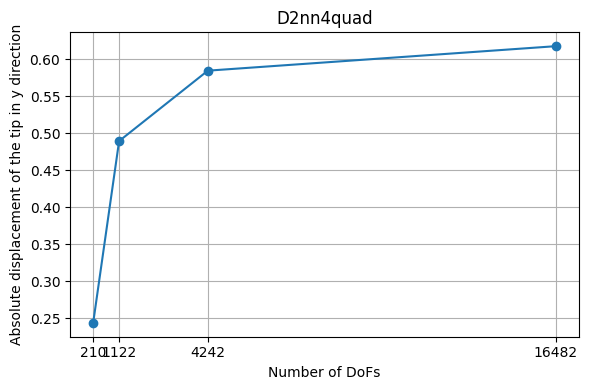

In [23]:
import matplotlib.pyplot as plt
import numpy as np

tipcenterdisp_D2nn4quad_lst = []
ndof_D2nn4quad_lst = []

tol = 1e-8  # Numerical tolerance for locating the tip node

for mesh_size in mesh_size_lst:
    coords, connect, displacements, mesh_ndof = meshsize2result_D2nn4quad_dict[mesh_size]
    disp = displacements.reshape(-1, 2)

    ndof_D2nn4quad_lst.append(mesh_ndof)

    # Find the node at the tip center (x = L_x, y = L_y / 2)
    ii = np.where(
        (np.abs(coords[:, 0] - L_x) < tol) & 
        (np.abs(coords[:, 1] - L_y / 2) < tol)
    )

    # Append the absolute y-displacement at the tip
    tipcenterdisp_D2nn4quad_lst.append(np.abs(disp[ii, 1][0]))

# Plot
plt.figure(figsize=(6, 4))
plt.plot(
    ndof_D2nn4quad_lst,
    tipcenterdisp_D2nn4quad_lst,
    marker='o',
    linestyle='-'
)

plt.xticks(ndof_D2nn4quad_lst)
plt.xlabel("Number of DoFs")
plt.ylabel("Absolute displacement of the tip in y direction")
plt.title("D2nn4quad")
plt.grid(True)
plt.tight_layout()
plt.show()


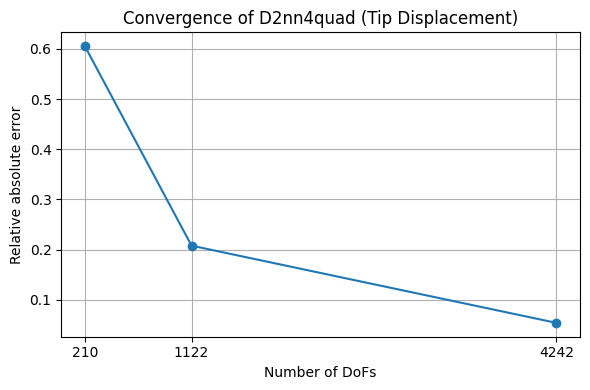

In [27]:
# Reference value from the finest mesh
ref_val = tipcenterdisp_D2nn4quad_lst[-1]

# Compute relative absolute error for each mesh
rel_error_lst = [
    np.abs(val - ref_val) / np.abs(ref_val)
    for val in tipcenterdisp_D2nn4quad_lst[:-1]
]

# Plot
plt.figure(figsize=(6, 4))
plt.plot(
    ndof_D2nn4quad_lst[:-1],
    rel_error_lst,
    marker='o',
    linestyle='-'
)

plt.xticks(ndof_D2nn4quad_lst[:-1])
plt.xlabel("Number of DoFs")
plt.ylabel("Relative absolute error")
plt.title("Convergence of D2nn4quad (Tip Displacement)")
plt.grid(True)
plt.tight_layout()
plt.show()


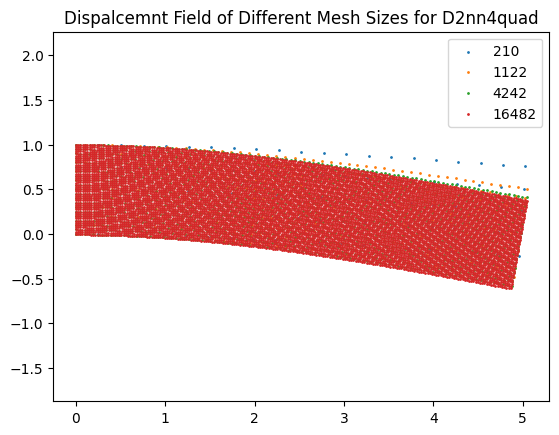

In [30]:
%matplotlib inline
ndof_D2nn4quad_lst = []
plt.figure()
for mesh_size in mesh_size_lst:
    coords, connect, displacements, mesh_ndof = meshsize2result_D2nn4quad_dict[ mesh_size ]
    ndof_D2nn4quad_lst.append(mesh_ndof)
    disp = displacements.reshape( -1, 2 )
    init_conf = coords.copy()
    final_conf = init_conf + disp
    
    plt.scatter( final_conf[:, 0], final_conf[:, 1], s = 1 )
plt.axis('equal')
plt.legend(ndof_D2nn4quad_lst)
plt.title('Dispalcemnt Field of Different Mesh Sizes for D2nn4quad')
plt.show()


In [28]:
#--- Geometry Parameters ---
ratio = 5
L_y = 1                          # Width
L_x = ratio * L_y               # Length

#--- Mesh Sizes: (N_x, N_y) ---
mesh_size_lst = [
    (ratio * 4, 4),
    (ratio * 10, 10),
    (ratio * 20, 20),
    (ratio * 40, 40)
]
# mesh_size_lst = [(ratio * 4, 4)]  # For quick testing

#--- Element and Solver Setup ---
ele_type = 'D2_nn8_quad'        # Type of element for the mesh
q = -0.05                       # Applied traction in x-direction
nr_num_steps = 10               # Number of Newton-Raphson steps

#--- Run Simulation and Collect Results ---
meshsize2result_D2nn8quad_dict = {'ele_type': ele_type}

for mesh_size in mesh_size_lst:
    N_x, N_y = mesh_size
    coords, connect, displacements_all = solve_hyperelastic_rect_mesh(
        ele_type, L_x, L_y, N_x, N_y, q, nr_num_steps
    )
    mesh_ndof = calc_mesh_dof(ele_type, coords)
    meshsize2result_D2nn8quad_dict[mesh_size] = (
        coords,
        connect,
        displacements_all[-1],  # Final displacement field
        mesh_ndof
    )


Step 0, load factor = 0.100
Iteration 1, Correction=1.000000e+00, Residual=3.183305e-06, tolerance=1.000000e-09
Iteration 2, Correction=6.377109e-03, Residual=5.063750e-04, tolerance=1.000000e-09
Iteration 3, Correction=1.007486e-05, Residual=1.154560e-07, tolerance=1.000000e-09
Iteration 4, Correction=2.669069e-09, Residual=1.565501e-13, tolerance=1.000000e-09
Iteration 5, Correction=1.709251e-15, Residual=6.910237e-16, tolerance=1.000000e-09
Step 1, load factor = 0.200
Iteration 1, Correction=4.999524e-01, Residual=3.183305e-06, tolerance=1.000000e-09
Iteration 2, Correction=3.188262e-03, Residual=5.060378e-04, tolerance=1.000000e-09
Iteration 3, Correction=9.769347e-05, Residual=1.153125e-07, tolerance=1.000000e-09
Iteration 4, Correction=3.390347e-08, Residual=2.418230e-11, tolerance=1.000000e-09
Iteration 5, Correction=3.322320e-15, Residual=8.351404e-16, tolerance=1.000000e-09
Step 2, load factor = 0.300
Iteration 1, Correction=3.331612e-01, Residual=3.183305e-06, tolerance=1.000

MemoryError: Unable to allocate 17.9 GiB for an array with shape (48962, 48962) and data type float64

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

tipcenterdisp_D2nn8quad_lst = []
ndof_D2nn8quad_lst = []

tol = 1e-8  # Numerical tolerance for locating the tip node

for mesh_size in mesh_size_lst:
    coords, connect, displacements, mesh_ndof = meshsize2result_D2nn8quad_dict[mesh_size]
    disp = displacements.reshape(-1, 2)

    ndof_D2nn8quad_lst.append(mesh_ndof)

    # Find the node at the tip center (x = L_x, y = L_y / 2)
    ii = np.where(
        (np.abs(coords[:, 0] - L_x) < tol) & 
        (np.abs(coords[:, 1] - L_y / 2) < tol)
    )

    # Append the absolute y-displacement at the tip
    tipcenterdisp_D2nn8quad_lst.append(np.abs(disp[ii, 1][0]))

# Plot
plt.figure(figsize=(6, 4))
plt.plot(
    ndof_D2nn8quad_lst,
    tipcenterdisp_D2nn8quad_lst,
    marker='o',
    linestyle='-'
)

plt.xticks(ndof_D2nn8quad_lst)
plt.xlabel("Number of DoFs")
plt.ylabel("Absolute displacement of the tip in y direction")
plt.title("D2nn8quad")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Reference value from the finest mesh
ref_val = tipcenterdisp_D2nn8quad_lst[-1]

# Compute relative absolute error for each mesh
rel_error_lst = [
    np.abs(val - ref_val) / np.abs(ref_val)
    for val in tipcenterdisp_D2nn8quad_lst[:-1]
]

# Plot
plt.figure(figsize=(6, 4))
plt.plot(
    ndof_D2nn8quad_lst[:-1],
    rel_error_lst,
    marker='o',
    linestyle='-'
)

plt.xticks(ndof_D2nn8quad_lst[:-1])
plt.xlabel("Number of DoFs")
plt.ylabel("Relative absolute error")
plt.title("Convergence of D2nn4quad (Tip Displacement)")
plt.grid(True)
plt.tight_layout()
plt.show()
